# Predykcja kursu KRW=X
### Projekt dyplomowy
#### Autor: Krzysztof Maciejewski

## Wstęp

Do pobierania danych o kursach wykorzystamy bibliotekę **yfinance**, która pozwala pobrać historyczne dane giełdowe z Yahoo Finance.

In [1]:
#!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
# kurs USD/KRW
krw = yf.Ticker('KRW=X')
history = krw.history(period='max', interval='1d')
history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-01,1197.300049,1203.500000,1195.000000,1198.400024,0,0,0
2003-12-02,1198.099976,1198.500000,1186.199951,1195.000000,0,0,0
2003-12-03,1195.000000,1198.400024,1192.500000,1192.500000,0,0,0
2003-12-04,1192.599976,1197.900024,1174.800049,1190.099976,0,0,0
2003-12-05,1189.400024,1193.800049,1178.599976,1184.699951,0,0,0


In [3]:
history.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4523.000000,4523.000000,4523.000000,4523.000000,4523.0,4523.0,4523.0
mean,1105.723092,1116.436149,1099.626872,1105.881631,0.0,0.0,0.0
std,97.939720,316.561111,96.869642,97.600677,0.0,0.0,0.0
min,879.500000,905.140015,872.799988,886.679993,0.0,0.0,0.0
25%,1055.989990,1061.475037,1050.549988,1056.049988,0.0,0.0,0.0
50%,1118.599976,1123.849976,1114.449951,1118.500000,0.0,0.0,0.0
75%,1159.479980,1164.599976,1153.000000,1159.309998,0.0,0.0,0.0
max,1571.500000,21353.000000,1546.199951,1571.400024,0.0,0.0,0.0


<AxesSubplot:xlabel='Date', ylabel='Kurs zamknięcia'>

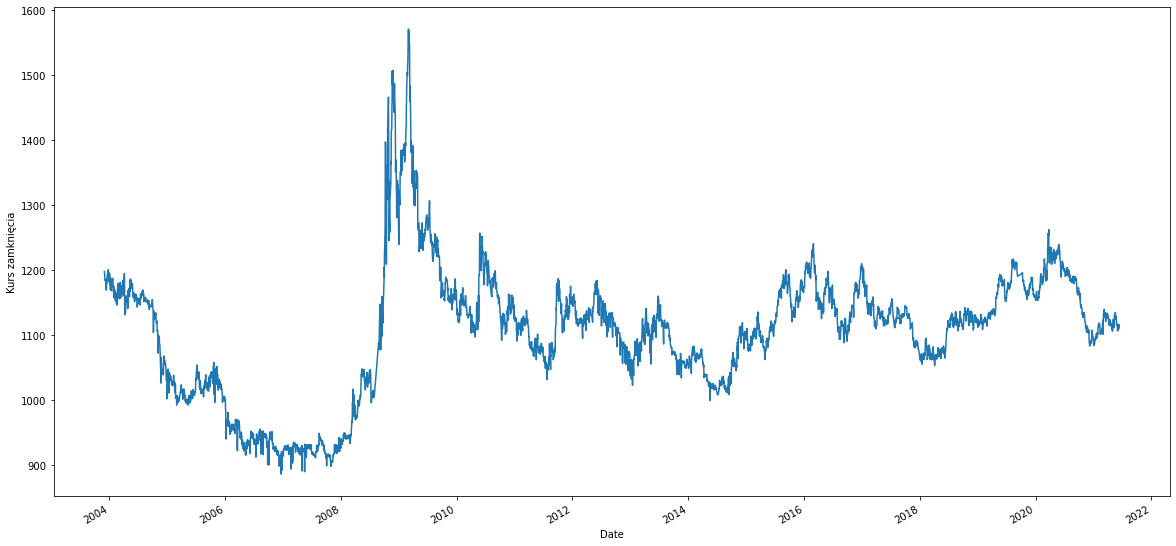

In [4]:
history.Close.plot(ylabel = "Kurs zamknięcia", figsize=(20,10))

In [5]:
history = history[history.index > '2011-01-01']

Generujemy atrybut wyrażający procentową zmianę ceny zamkniecia względem poprzedniego dnia. Będzie to target dla trenowanych sieci.

In [6]:
close_change = [0]
for i in range(0, len(history) - 1):
    close_change.append(history.iloc[i+1, 3] / history.iloc[i, 3] - 1)

history['close_change'] = pd.Series(close_change, index=history.index)
history.drop(history.index[0], inplace=True)
history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_change
Date,,,,,,,,
2011-01-04,1124.599976,1127.400024,1117.150024,1124.800049,0,0,0,0.002138
2011-01-05,1121.599976,1127.400024,1121.599976,1122.000000,0,0,0,-0.002489
2011-01-06,1127.699951,1130.199951,1115.699951,1128.000000,0,0,0,0.005348
2011-01-07,1125.099976,1125.800049,1117.699951,1125.800049,0,0,0,-0.001950
2011-01-10,1123.800049,1131.000000,1121.000000,1124.000000,0,0,0,-0.001599


Trzeba przekształcić dane, aby dopasować je do wejścia i wyjścia sieci. Poniżej znajduje się funkcja do wygenerowania okien czasowych (parametr value_num to liczba poprzednich dni, które chcemy uwzględnić na wejściu sieci).

In [7]:
#https://towardsdatascience.com/is-it-possible-to-predict-stock-prices-with-a-neural-network-d750af3de50b

def generate_time_series(X, y, period):
    tsg = TimeseriesGenerator(X, y, length=period, batch_size=len(X))
    return tsg[0]

# pokazanie wygenerowanych danych
inputs, targets = generate_time_series(history['Close'], history['close_change'], 2)

print(inputs) # znormalizowane ceny kursu
print(targets) # procentowa zmiana względem poprzendiego dnia

[[1124.80004883 1122.        ]
 [1122.         1128.        ]
 [1128.         1125.80004883]
 ...
 [1115.43994141 1109.68005371]
 [1109.68005371 1109.31994629]
 [1109.31994629 1116.89001465]]
[ 0.00534759 -0.00195031 -0.00159891 ... -0.00032451  0.00682406
 -0.00403801]


Tworzymy funkcję do skalowania i normalizacji. Scaler skalujemy na danych treningowych i potem to skalowanie aplikujemy na dane testowe.

In [8]:
def split_and_normalize(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

Tworzymy funkcję generująca model sieci dla n wejść i danej funckji aktywacji:

In [9]:
def create_MLP_model(n, hn, hl, activation):
    m = models.Sequential()
    m.add(layers.Dense(hn, activation=activation, input_shape=(n,)))
    if hl > 1:
        m.add(layers.Dense(hn, activation=activation))
    m.add(layers.Dense(1))
    return m

def create_LSTM_model(n, hn, hl):
    m = models.Sequential()
    if hl > 1:
        m.add(layers.LSTM(units = hn, return_sequences=True, input_shape=(n,1)))
        m.add(layers.Dropout(0.2))
        m.add(layers.LSTM(units = hn))
        m.add(layers.Dropout(0.2))
    else:
        m.add(layers.LSTM(units = hn, input_shape=(n,1)))
        m.add(layers.Dropout(0.2))
        
    m.add(layers.Dense(1))
    return m

## Sieci typu C

Na początku wytrenujemy sieci w modelu C - SSN, czyli na wejściu będzie N wartości odpowiadających kursom zamknięcia USD/KRW z N poprzednich dni. Wytrenowane zostanie kilka sieci dla różnych wartośći N.

Tworzymy funkcję do obliczania liczby neuronów w warstwie ukrytej na podstawie liczby wejść.

In [10]:
def get_n(hn_formula, inputs):
    if hn_formula == "n+1":
        return inputs + 1
    elif hn_formula == "1.5n":
        return int(inputs * 1.5)
    else:
        return 2 * inputs + 1

Tworzymy funkcję do wytrenowania sieci neuronowych dla zadanej listy N poprzednich dni do uwzględnienia. 

In [11]:
def train_models(X, y, model, n_days_arr, hn_formula, hl, activation = "tanh", lr=0.01):
    
    models = {}
    
    for inputs in n_days_arr:
        model_inputs, targets = generate_time_series(X, y, inputs)
        hn = get_n(hn_formula, inputs)
        
        if model == 'MLP':
            X_train, X_test, y_train, y_test = split_and_normalize(model_inputs, targets)
            m = create_MLP_model(inputs, hn, hl, activation)
            
        elif model == 'LSTM':
            X_train, X_test, y_train, y_test = split_and_normalize(model_inputs, targets)
            X_train = X_train.reshape((len(X_train), inputs, 1))
            X_test = X_test.reshape((len(X_test), inputs, 1))
            m = create_LSTM_model(inputs, hn, hl)
        
        print('\nTraining ' + model + " (n=" + str(inputs) + "):\n")
        m.compile(optimizer=keras.optimizers.Adam(lr=lr), loss='mse') 
        h = m.fit(X_train, y_train,
                  epochs=30,
                  batch_size=32,
                  validation_data=(X_test, y_test))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
        
    return models

Tworzymy funkcję do wizualizacji tworzonych modeli:

In [12]:
def models_results(trained_models, n_inputs):

    bias = []
    variance = []
    for k, v in trained_models.items():
        train_history = v['history']
        loss = train_history['loss'][-1]
        val_loss = train_history['val_loss'][-1]
        print("inputs: {}, loss: {:0.3e}, val_loss: {:0.3e}".format(k, loss, val_loss))
        bias.append(loss)
        variance.append(val_loss)

    plt.plot(n_inputs, bias)
    plt.plot(n_inputs, variance)
    plt.xlabel('Liczba poprzednich dni uwzględnionych w modelu') 
    plt.ylabel('Błąd')
    plt.title("Dokładność modelu dla danej ilości wejść")
    plt.legend(['Błąd uczenia', 'Błąd testowania'])
    
    return variance

Trenujemy model:

In [13]:
C_models = [] # przewchowywanie modeli typu C do późniejszej wizualizacji

In [14]:
X = history['Close']
y = history['close_change']
model = "MLP"
inputs = list(range(2, 15, 1))
hn_formula = "n+1" # n+1 / 1.5n / 2n+1 
hidden_layers = 1
activation = "tanh"
learning_rate = 0.01

trained_models = train_models(X, y, model, inputs, hn_formula, hidden_layers, activation=activation, lr=learning_rate)

Wyświetlamy wyniki poszczególnych modeli:

In [15]:
C_models.append(models_results(trained_models, inputs))

## Sieci typu AT

Dla tych sieci na wejściu przekazywane są wybrane wskaźniki analizy techniczne.

Average True Range (14 dni):

In [16]:
#https://www.learnpythonwithrune.org/calculate-the-average-true-range-atr-easy-with-pandas-dataframes/

high_low = history['High'] - history['Low']
high_close = np.abs(history['High'] - history['Close'].shift())
low_close = np.abs(history['Low'] - history['Close'].shift())

ranges = pd.concat([high_low, high_close, low_close], axis=1)
tr = np.max(ranges, axis=1)

history['ATR'] = tr.rolling(14).sum()/14

Bollinger Bands (20 dni):

In [17]:
#https://codingandfun.com/bollinger-bands-pyt/

ma20 = history['Close'].rolling(window=20).mean()
std20d = history['Close'].rolling(window=20).std() 

history['BB_upper'] = ma20 + (std20d * 2)
history['BB_lower'] = ma20 - (std20d * 2)

Momentum (10 dni):

In [18]:
history['Momentum'] = history['Close'].rolling(window=10).apply(lambda x: x.iloc[1] - x.iloc[0])
history.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,close_change,ATR,BB_upper,BB_lower,Momentum
Date,,,,,,,,,,,,
2021-06-04,1115.270020,1118.849976,1108.880005,1115.439941,0,0,0,0.005009,8.773586,1136.883240,1103.534753,-4.600098
2021-06-07,1109.680054,1113.170044,1108.550049,1109.680054,0,0,0,-0.005164,8.416434,1137.036254,1103.152747,-0.809937
2021-06-08,1109.410034,1117.030029,1108.540039,1109.319946,0,0,0,-0.000325,8.149292,1137.296035,1102.270958,-5.859985
2021-06-09,1116.859985,1117.949951,1111.300049,1116.890015,0,0,0,0.006824,8.311436,1137.264278,1102.168718,1.780029
2021-06-10,1114.959961,1117.530029,1111.339966,1112.380005,0,0,0,-0.004038,8.159302,1135.656315,1101.854683,-4.450073


 Moving Average Convergence Divergence (MACD):

In [19]:
#https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/

exp1 = history['Close'].ewm(span=12, adjust=False).mean()
exp2 = history['Close'].ewm(span=26, adjust=False).mean()
history['MACD'] = exp1 - exp2

Średnia ruchoma (5 i 20 dni):

In [20]:
history['MA5'] = history['Close'].rolling(window=5).mean()
history['MA20'] = history['Close'].rolling(window=20).mean()

Relative Strength Index (RSI):

In [21]:
#https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/

delta = history['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
history['RSI'] = 100 - 100/(1+rs)

Stochastic Slow i Fast:

(K% w Slow jest tym samym co D% w Fast, więc bierzemy tylko jedną z tych wartości)

In [22]:
#https://stackoverflow.com/questions/30261541/slow-stochastic-implementation-in-python-pandas

def stochastics(dataframe, k, d):

    df = dataframe.copy()

    low_min  = df['Low'].rolling(window = k).min()
    high_max = df['High'].rolling(window = k).max()

    # Fast Stochastic
    k_fast = 100 * (df['Close'] - low_min)/(high_max - low_min)
    d_fast = k_fast.rolling(window = d).mean()

    # Slow Stochastic
    # k_slow = d_fast
    d_slow= d_fast.rolling(window = d).mean()

    return k_fast, d_fast, d_slow


history['K_fast'], history['D_fast'], history['D_slow']= stochastics(history, 14, 3 )

Usuwamy kilka początkowych wierszy w których znajdują się wartości NaN po wyliczeniu wskaźników AT.



In [23]:
history.dropna(inplace=True)

Tworzymy funkcję do uczenia modeli:

In [24]:
def train_model_AT(X, y, model, hn_formula, hl, activation = "tanh", lr=0.01):

    inputs = len(X.columns)
    hn = get_n(hn_formula, inputs)
        
    if model == 'MLP':
        X_train, X_test, y_train, y_test = split_and_normalize(X, y)
        m = create_MLP_model(inputs, hn, hl, activation)
            
    elif model == 'LSTM':
        
        X_train, X_test, y_train, y_test = split_and_normalize(X, y)
        X_train = X_train.reshape((len(X_train), inputs, 1))
        X_test = X_test.reshape((len(X_test), inputs, 1))
        m = create_LSTM_model(inputs, hn, hl)
        
    print('\nTraining ' + model + ":\n")
    m.compile(optimizer=keras.optimizers.Adam(lr=lr), loss='mse') 
    h = m.fit(X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test))
    model_info = {'model': m, 'history': h.history}
        
    return model_info

Trenujemy modele AT:

In [27]:
at = ['ATR', 'BB_upper', 'BB_lower', 'Momentum', 'MACD', 'MA5', 'MA20', 'RSI', 'K_fast', 'D_fast', 'D_slow']
X = history[at]
y = history['close_change']
model = "LSTM"
hn_formula = "2n+1" # n+1 / 1.5n / 2n+1 
hidden_layers = 2
activation = "relu"
learning_rate = 0.001

trained_model = train_model_AT(X, y, model, hn_formula, hidden_layers, activation=activation, lr=learning_rate)


Training LSTM:

Epoch 1/10
67/67 [==============================] - 2s 34ms/step - loss: 1.7424e-04 - val_loss: 4.9117e-05
Epoch 2/10
67/67 [==============================] - 1s 20ms/step - loss: 7.6294e-05 - val_loss: 5.0113e-05
Epoch 3/10
67/67 [==============================] - 1s 21ms/step - loss: 6.4149e-05 - val_loss: 4.5641e-05
Epoch 4/10
67/67 [==============================] - 2s 26ms/step - loss: 6.2358e-05 - val_loss: 4.6091e-05
Epoch 5/10
67/67 [==============================] - 2s 26ms/step - loss: 5.8368e-05 - val_loss: 4.6972e-05
Epoch 6/10
67/67 [==============================] - 2s 26ms/step - loss: 5.7691e-05 - val_loss: 4.7412e-05
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 5.7239e-05 - val_loss: 4.7008e-05
Epoch 8/10
67/67 [==============================] - 2s 23ms/step - loss: 5.5484e-05 - val_loss: 4.6911e-05
Epoch 9/10
67/67 [==============================] - 1s 18ms/step - loss: 5.3536e-05 - val_loss: 4.4961e-05
Epoch 10/10
67/67 [=

## Sieci typu C + AT

Na koniec stworzono sieci przyjmujące na wejście zarówno wskaźniki analizy technicznej, jak i ceny zamknięcia z N poprzednich dni.

Tworzymy funckję do łączenia okien czasowych i wskaźników AT do postaci jednej tabeli.

In [29]:
def merge_CAT(X_c, X_at, inputs):
    X_at = X_at.iloc[inputs:,:].values
    return np.concatenate((X_c, X_at),axis=1)

Tworzymy funkcję do uczenia modeli C+AT:

In [57]:
def train_models_CAT(X_c, X_at, y, model, n_days_arr, hn_formula, hl, activation = "tanh", lr=0.01):
    
    models = {}
    
    for days in n_days_arr:
        X_c_trans, y_trans = generate_time_series(X_c, y, days)
        X = merge_CAT(X_c_trans, X_at, days)
        
        inputs = days + len(X_at.columns)
        hn = get_n(hn_formula, inputs)
        
        if model == 'MLP':
            X_train, X_test, y_train, y_test = split_and_normalize(X, y_trans)
            m = create_MLP_model(inputs, hn, hl, activation)
            
        elif model == 'LSTM':
            X_train, X_test, y_train, y_test = split_and_normalize(X, y_trans)
            X_train = X_train.reshape((len(X_train), inputs, 1))
            X_test = X_test.reshape((len(X_test), inputs, 1))
            m = create_LSTM_model(inputs, hn, hl)
        
        print('\nTraining ' + model + " (n=" + str(inputs) + "):\n")
        m.compile(optimizer=keras.optimizers.Adam(lr=lr), loss='mse') 
        h = m.fit(X_train, y_train,
                  epochs=10,
                  batch_size=32,
                  validation_data=(X_test, y_test))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
        
    return models

Tworzymy modele C+AT:

In [50]:
#CAT_models = [] # do zapisywania modeli


Training LSTM (n=13):

Epoch 1/10
67/67 [==============================] - 3s 45ms/step - loss: 0.0012 - val_loss: 6.6231e-05
Epoch 2/10
67/67 [==============================] - 2s 34ms/step - loss: 6.7140e-05 - val_loss: 5.3873e-05
Epoch 3/10
67/67 [==============================] - 2s 33ms/step - loss: 5.8254e-05 - val_loss: 5.5791e-05
Epoch 4/10
67/67 [==============================] - 2s 31ms/step - loss: 5.6036e-05 - val_loss: 5.5475e-05
Epoch 5/10
67/67 [==============================] - 2s 25ms/step - loss: 5.6098e-05 - val_loss: 5.3150e-05
Epoch 6/10
67/67 [==============================] - 2s 30ms/step - loss: 5.3580e-05 - val_loss: 5.2065e-05
Epoch 7/10
67/67 [==============================] - 2s 29ms/step - loss: 5.5275e-05 - val_loss: 5.0883e-05
Epoch 8/10
67/67 [==============================] - 2s 33ms/step - loss: 5.2975e-05 - val_loss: 5.0815e-05
Epoch 9/10
67/67 [==============================] - 2s 32ms/step - loss: 5.1783e-05 - val_loss: 5.0141e-05
Epoch 10/10
67/67

67/67 [==============================] - 3s 41ms/step - loss: 4.6070e-05 - val_loss: 3.3299e-05
Epoch 7/10
67/67 [==============================] - 2s 37ms/step - loss: 4.4756e-05 - val_loss: 3.3510e-05
Epoch 8/10
67/67 [==============================] - 3s 39ms/step - loss: 4.0924e-05 - val_loss: 3.3836e-05
Epoch 9/10
67/67 [==============================] - 3s 46ms/step - loss: 3.9823e-05 - val_loss: 2.8632e-05
Epoch 10/10
67/67 [==============================] - 3s 40ms/step - loss: 3.9774e-05 - val_loss: 2.8405e-05

Training LSTM (n=21):

Epoch 1/10
67/67 [==============================] - 5s 77ms/step - loss: 0.0025 - val_loss: 4.7637e-05
Epoch 2/10
67/67 [==============================] - 3s 50ms/step - loss: 6.5441e-05 - val_loss: 4.2401e-05
Epoch 3/10
67/67 [==============================] - 3s 47ms/step - loss: 5.6189e-05 - val_loss: 4.0679e-05
Epoch 4/10
67/67 [==============================] - 3s 43ms/step - loss: 5.1773e-05 - val_loss: 4.0022e-05
Epoch 5/10
67/67 [=========

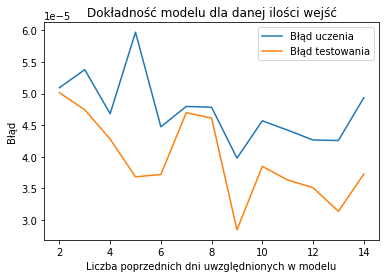

In [59]:
X_c = history['Close']
X_at = history[at]
y = history['close_change']
inputs = list(range(2, 15, 1))
model = "LSTM"
hn_formula = "2n+1" # n+1 / 1.5n / 2n+1 
hidden_layers = 2
activation = "relu"
learning_rate = 0.01

trained_models = train_models_CAT(X_c, X_at, y, model, inputs, hn_formula, hidden_layers, activation=activation, lr=learning_rate)

Wyświetlamy wyniki modeli C+AT:

In [ ]:
CAT_models.append(models_results(trained_models, inputs))